# Latitude by Latitude Land Byrne 2021 Theory
This looks at applying the exact theory from Byrne 2021 to each latitude individually and then does an area weighted average of each latitude in a given region.

In [86]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
from isca_tools.papers.byrne_2021 import get_delta_temp_quant_theory, get_px, get_quant_ind, get_gamma
import warnings

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]
max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']
p_surface = float(ds[0].pfull) * 100  # pressure where surface temperature is computed - same for all ds

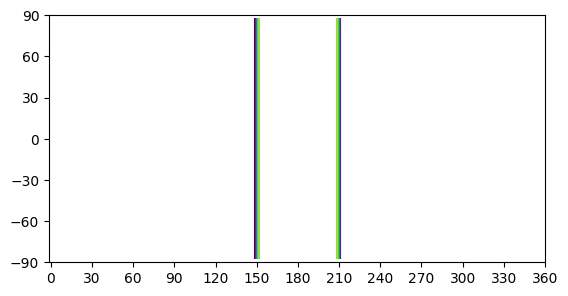

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get two datasets, `ds_all`, one for ocean and one for land, for a given latitude bin.

In [52]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = True
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [98]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
season = 'summer'
# season = 'all'

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65

ds_all = {'land':[], 'ocean': []}
ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_use = ds_use.load()
        for surf in ['land', 'ocean']:
            ds_all[surf] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            pbar.update(1)

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

This shows the moist static energy percentiles (y-axis) corresponding to the average moist static energy of days exceeding the given temperature percentile.

The ocean plot shows good agreement with Byrne 2021, and this also shows that for land, in the warmer simulation, there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ over land, but in byrne 2021, we see a decrease.

In [99]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
surfaces = ['ocean', 'land']
n_surf = len(surfaces)
quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)
n_lat = len(ds_all['ocean'][0].lat)
lat_weights = np.cos(np.deg2rad(ds_all['ocean'][0].lat))     # latitude area weighting is just the cosine

# surface values corresponding to the average obove a given percentile in temperature
temp_quant = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
sphum_quant = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
mse_quant = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
rh_quant_l = np.zeros((n_exp, n_lat, n_quant))


with tqdm(total=n_exp*n_quant*n_surf*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                for surf in surfaces:
                    use_ind = get_quant_ind(ds_all[surf][i].temp[k], quant)
                    temp_quant[surf][i, k, j] = ds_all[surf][i].temp[k][use_ind].mean()
                    sphum_quant[surf][i, k, j] = ds_all[surf][i].sphum[k][use_ind].mean()
                    mse_quant[surf][i, k, j] = moist_static_energy(ds_all[surf][i].temp[k][use_ind],
                                                                   ds_all[surf][i].sphum[k][use_ind],
                                                                   ds_all[surf][i].height[k][use_ind]).mean()
                    if surf == 'land':
                        rh_quant_l[i, k, j] = (ds_all[surf][i].sphum[k][use_ind]/
                                               sphum_sat(ds_all[surf][i].temp[k][use_ind], p_surface)).mean()
                    pbar.update(1)

100%|██████████| 7200/7200 [00:35<00:00, 203.09it/s]


In [100]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
for surf in surfaces:
    for k in range(n_lat):
        mse_quant_px[surf][:, k] = get_px([ds_all[surf][i].sel(lat=ds_all[surf][i].lat[k]) for i in range(n_exp)],
                                          mse_quant[surf][:, k], quant_plot)
p_x = np.round(mse_quant_px['land']).astype(int)
if p_x.max()>99:
    warnings.warn(f'Changing {(p_x>99).sum()} values to 99 from over 100')
    p_x = np.clip(p_x, -1, 99)

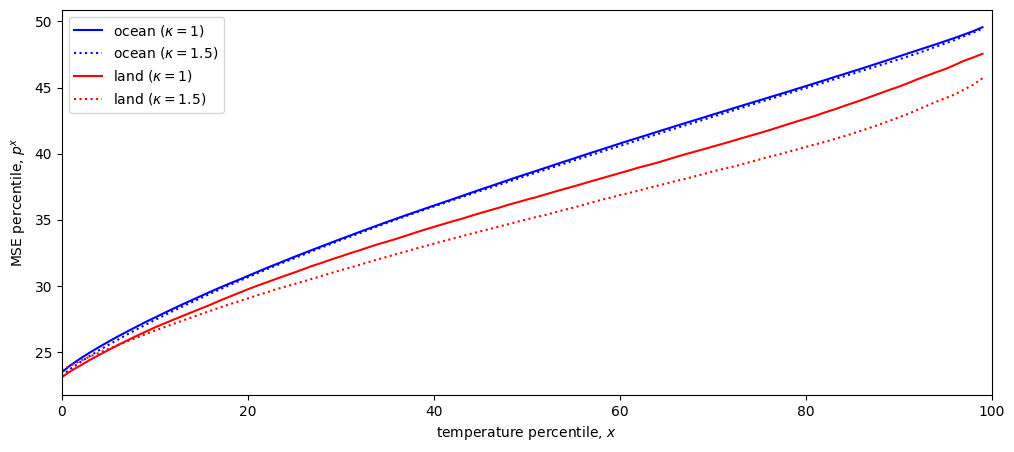

In [101]:
plt_color = {'land': 'red', 'ocean': 'blue'}
linestyles = ['-', ':']     # different for each kappa
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharex=True)
for surf in surfaces:
    for i in range(n_exp):
        ax.plot(quant_plot, np.average(mse_quant_px[surf][i], axis=0, weights=lat_weights), color=plt_color[surf],
                linestyle=linestyles[i], label=f'{surf} ($\kappa={tau_lw[i]}$)')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE percentile, $p^x$')
ax.set_xlim(0,100);

## Land to Ocean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3.

It seems pretty close to the results shown in the paper, implying that the assumption of equal change in MSE percentiles over land and ocean: $\delta h_L(p) = \delta h_O(p)$ may also be valid.

However, the scaling $\lambda(p) = \frac{\delta h_L(p)}{\delta h_O(p)}$, is clearly more than 1 for percentiles greater than 1, and the difference to 1 is more significant than in the paper.

The vertical black lines indicate the range of $p^x$ that corresponds to the complete range of $x$ from 0 to 100.

In [102]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
# mse as function of mse quantile not temp quantile
mse_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}

for i in range(n_exp):
        for k, ds_use in enumerate([ds_all['ocean'], ds_all['land']]):
            temp_quant2[surfaces[k]][i] = ds_use[i].temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            sphum_quant2[surfaces[k]][i] = ds_use[i].sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            mse = moist_static_energy(ds_use[i].temp, ds_use[i].sphum, ds_use[i].height)
            mse_quant2[surfaces[k]][i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

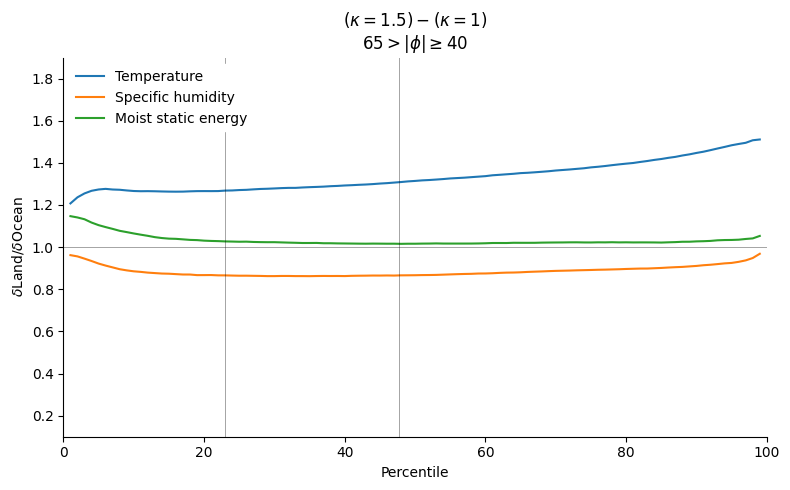

In [103]:
save_lambda_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
# don't plot the p=0 percentile as doesn't really make any sense
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    ax.plot(quant_plot[np.where(quant_plot>0)],
            np.average((var['land'][1]-var['land'][0])/(var['ocean'][1]-var['ocean'][0]), axis=0, weights=lat_weights
                       )[np.where(quant_plot>0)], label=labels[i])
ax.hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
ax.legend(loc='upper left', framealpha=1, edgecolor='w')
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta$Land/$\delta$Ocean')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax.vlines([np.average(p_x[0], axis=0, weights=lat_weights).min(), np.average(p_x[0], axis=0, weights=lat_weights).max()], 0, 2,
          color='k', linewidth=0.5, alpha=0.5)
ax.set_ylim(0.1,1.9)
ax.set_xlim(0, 100)
plt.tight_layout()
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for $\delta T_L^x$
Below, I try to replicate Figure 2 from the paper. This uses equation 5 in the paper which is based on the assumption of equal change in MSE percentiles over land and ocean: $\delta h_L(p) = \delta h_O(p)$ i.e. $\lambda(p) = 1$.

The theory does pretty well at low percentiles, but seems to get worse as $x$ increases, with the wrong trend being seen for the largest $x$.

In [104]:
# Get separate theory prediction for each latitude
temp_diff_land_theory = {'full': np.zeros((n_lat, n_quant)), 'const_rh': np.zeros((n_lat, n_quant))}
for i in temp_diff_land_theory:
    for k in range(n_lat):
        temp_diff_land_theory[i][k] = \
            get_delta_temp_quant_theory(temp_quant['land'][:, k, 0], sphum_quant['land'][:, k, 0], temp_quant['land'][:, k],
                                        temp_quant2['ocean'][:, k], sphum_quant['land'][:, k], sphum_quant2['ocean'][:, k],
                                        quant_plot, p_x[:, k], p_surface, True if i=='const_rh' else False)

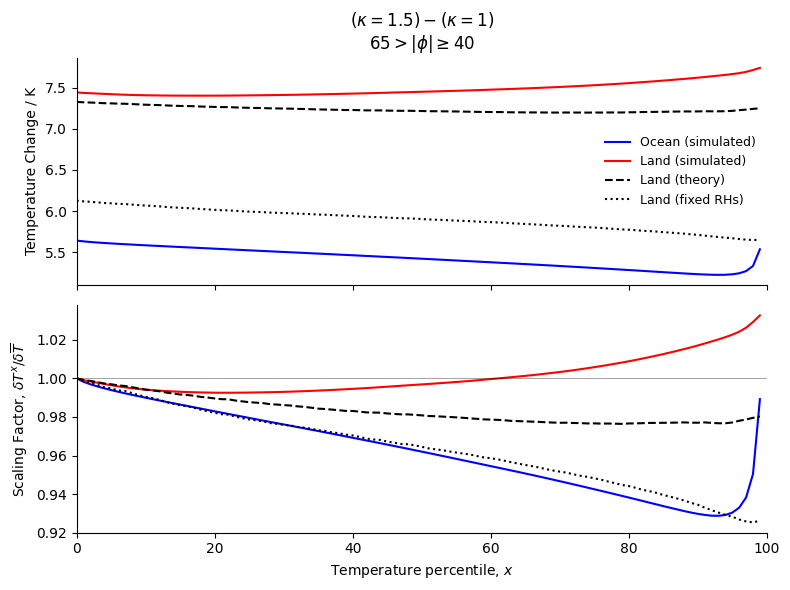

In [105]:
# Plot temperature change vs percentile
save_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
temp_diff_quant = {'ocean': [], 'land': []}
for surf in ['ocean', 'land']:
    temp_diff_quant[surf] = temp_quant[surf][1]-temp_quant[surf][0]
    ax[0].plot(quant_plot, np.average(temp_diff_quant[surf], axis=0, weights=lat_weights),
               label=f'{surf.capitalize()} (simulated)', color=plt_color[surf])
    ax[1].plot(quant_plot, np.average(temp_diff_quant[surf]/temp_diff_quant[surf][:, :1], axis=0, weights=lat_weights),
               color=plt_color[surf])
ax[0].plot(quant_plot, np.average(temp_diff_land_theory['full'], axis=0, weights=lat_weights),
           label=f'Land (theory)', linestyle='--', color='k')
ax[0].plot(quant_plot, np.average(temp_diff_land_theory['const_rh'], axis=0, weights=lat_weights),
           label=f'Land (fixed RHs)', linestyle=':', color='k')
ax[1].plot(quant_plot, np.average(temp_diff_land_theory['full']/temp_diff_land_theory['full'][:, :1], axis=0, weights=lat_weights),
           label=f'Land (theory)', linestyle='--', color='k')
ax[1].plot(quant_plot, np.average(temp_diff_land_theory['const_rh']/temp_diff_land_theory['const_rh'][:, :1], axis=0, weights=lat_weights),
           label=f'Land (fixed RHs)', linestyle=':', color='k')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].legend(fontsize=9, frameon=False)
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4, 8.5)
# ax[1].set_ylim(0.8, 1.5)
ax[1].hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
# ax[0].set_ylim(4, 8.5)
# ax[1].set_ylim(0.9, 1.25)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

### Gamma, $\gamma$, Plots
The below plot shows the $\gamma$ scaling parameters, as in Extended Figure 4.

In [106]:
gamma_t = np.zeros((n_exp, n_lat, n_quant))
gamma_r_o = np.zeros((n_exp, n_lat, n_quant))
e_param = np.zeros((n_exp, n_lat, n_quant))
eta_param = np.zeros((n_exp, n_lat, n_quant))
for k in range(n_lat):
    gamma_t[:, k], gamma_r_o[:, k], e_param[:, k], eta_param[:, k] = \
        get_gamma(temp_quant['land'][:, k, 0], temp_quant['land'][:, k], temp_quant2['ocean'][:, k], sphum_quant['land'][:, k],
                  sphum_quant2['ocean'][:, k], quant_plot, p_x[:, k], p_surface)
gamma_r_l = -eta_param/(100+e_param)

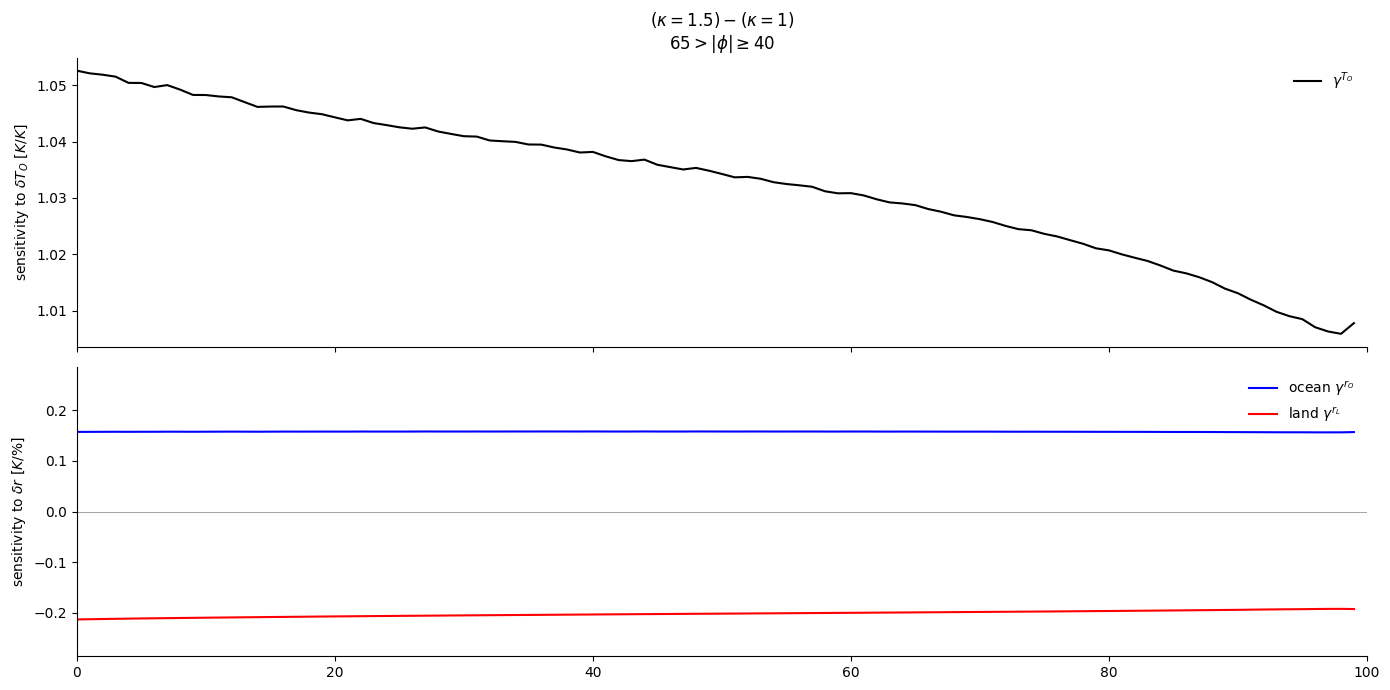

In [107]:
save_gamma_fig = False
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(gamma_t[0], axis=0, weights=lat_weights), color='k', label='$\gamma^{T_O}$')
ax[1].plot(quant_plot, np.average(gamma_r_o[0], axis=0, weights=lat_weights)/100, color='b', label='ocean $\gamma^{r_O}$')
ax[1].plot(quant_plot, np.average(gamma_r_l[0], axis=0, weights=lat_weights), color='r', label='land $\gamma^{r_L}$')
ax[1].hlines([0],0,100, color='k', lw=0.5, alpha=0.5)
ax[0].legend(frameon=False)
ax[0].set_ylabel('sensitivity to $\delta T_O$ [$K/K$]')
ax[1].legend(frameon=False)
ax[1].set_ylabel('sensitivity to $\delta r$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[1].set_ylim(-np.max([gamma_r_o[0].max()/100, np.abs(gamma_r_l[0]).max()]),
               np.max([gamma_r_o[0].max()/100, np.abs(gamma_r_l[0]).max()]))
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile.

In [108]:
rh_quant_l2 = sphum_quant['land'] / sphum_sat(temp_quant['land'], p_surface)

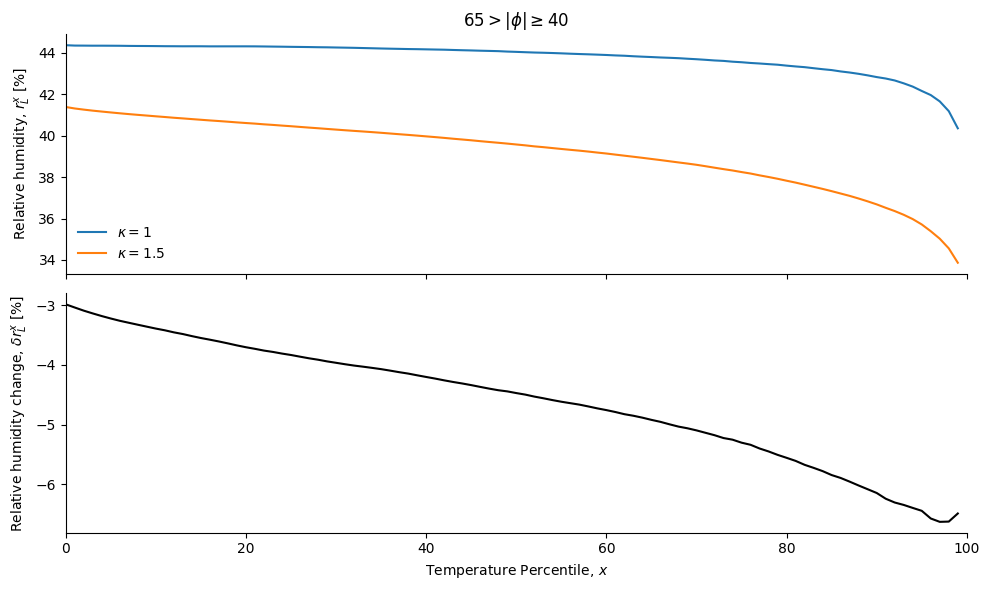

In [109]:
save_rh_fig = False
# choose which rh to plot - rh is mean over all RH values. rh2 is averaged sphum divided by sphum_sat evaluated at averaged temp.
# rh_use = rh_quant_l
rh_use = rh_quant_l2
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(rh_use[i], axis=0, weights=lat_weights) * 100, color=default_colors[i],
               label=f'$\kappa={tau_lw[i]}$')
ax[1].plot(quant_plot, np.average(rh_use[1]-rh_use[0], axis=0, weights=lat_weights) * 100, color='k')
ax[0].set_xlim(0,100)
# ax[0].set_ylim(14, 27)
# ax[1].set_ylim(-3, -0.4)
ax[-1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Relative humidity, $r_L^x$ [%]')
ax[1].set_ylabel('Relative humidity change, $\delta r_L^x$ [%]')
ax[0].legend(frameon=False)
ax[0].set_title(f'${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

Note, $r_L^x$ is equal to the specific humidity averaged over days exceeding the $x$ percentile of temperature, $q^x$, divided by the saturation specific humidity evaluated at the temperature averaged all days exceeding the $x$ percentile of temperature, $q_{sat}(T^x_L)$.
This is different from the average of all relative humidities over days exceeding the $x$ percentile of temperature.

The former is shown in blue below, with the latter in black.

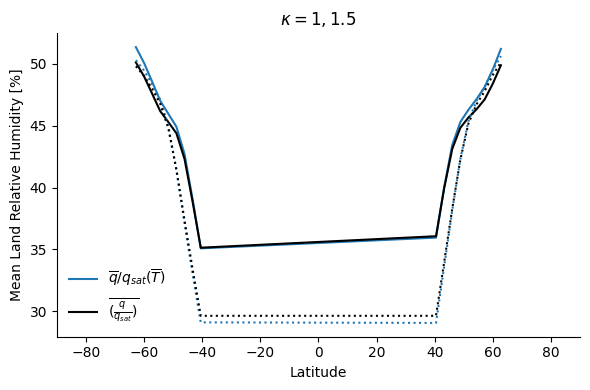

In [110]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_all['land'][0].lat, rh_quant_l2[0, :, 0]*100, color=default_colors[0], label='$\overline{q} / q_{sat}(\overline{T})$')
ax.plot(ds_all['land'][0].lat, rh_quant_l[0, :, 0]*100, color='k', label='$\overline{(\\frac{q}{q_{sat}})}$')
ax.plot(ds_all['land'][0].lat, rh_quant_l2[1, :, 0]*100, color=default_colors[0], linestyle=':')
ax.plot(ds_all['land'][0].lat, rh_quant_l[1, :, 0]*100, color='k', linestyle=':')
ax.set_xlim(-90,90)
ax.legend(frameon=False)
ax.set_ylabel('Mean Land Relative Humidity [%]')
ax.set_xlabel('Latitude')
ax.set_title(f'$\kappa = {tau_lw[0]}, {tau_lw[1]}$')
plt.tight_layout();